In [1]:
import numpy as np
import pandas as pd
from google.colab import files
import io
import os
import ast
from google.colab import drive
drive.mount('/content/drive')
save_path = '/content/drive/MyDrive/movies/5000_movies.csv'

df = pd.read_csv(save_path)
df['genres'] = df['genres'].apply(ast.literal_eval)

Mounted at /content/drive


In [2]:
pip install transformers


In [3]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import pandas as pd
from transformers import BertTokenizer, BertModel
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report
import numpy as np
from torch.optim import AdamW

In [4]:
# prompt: open random 20 movies with full width, i need all cols. i need the cols to have full widths, i desctiption is cut out , i need full

import pandas as pd
pd.set_option('display.max_colwidth', None)

# Assuming 'df' is your DataFrame and already loaded as shown in your initial code
# If not, make sure to load it before this line

# Sample 20 random movies
random_movies = df.sample(n=2)

# Display the sampled movies
random_movies


,movie_id,movie_name,year,genre,description,director,star,Genre,genres
12773,tt1662509,Haereul samkin gaemi,2010,"Drama, Fantasy","'Can ants swim?' He asks himself the same question every morning while his friend lying under the bed watches him quietly, waiting for the rain.",Rani Gillioz,"Seonha Hwang, \nSaea Jeong, \nSoekjun Lee, \nSangjin Na",Fantasy,[Fantasy]
9515,tt6125438,Cover Me,2020,"Drama, Family","Mia Stone is faced with an eerie supernatural opportunity when a strange encounter with an eccentric man gives her a second chance at saving her company, marriage, family, and future.",Phillip Abraham,"Jules Willcox, \nDanny Trejo, \nJesse Metcalfe, \nJeff Grace",Family,[Family]


In [5]:
# Encode genres as multi-label
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df['genres'].apply(eval if isinstance(df['genres'].iloc[0], str) else lambda x: x))
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
tokens = tokenizer(
    df['description'].tolist(),
    truncation=True,
    padding=True,
    max_length=512,
    return_tensors='pt'
)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [6]:
class MovieDataset(Dataset):
    def __init__(self, tokens, labels):
        self.tokens = tokens
        self.labels = torch.tensor(labels).float()

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.tokens.items()}
        item['labels'] = self.labels[idx]
        return item
dataset = MovieDataset(tokens, y)
loader = DataLoader(dataset, batch_size=8, shuffle=True)


In [7]:
class BertGenreClassifier(nn.Module):
    def __init__(self, num_labels):
        super().__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0]
        x = self.dropout(cls_output)

        return torch.sigmoid(self.classifier(x))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BertGenreClassifier(num_labels=y.shape[1]).to(device)

optimizer = AdamW(model.parameters(), lr=5e-7)
loss_fn = nn.BCELoss()

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Epoch 1 - Train Loss: 0.4084 | Val Loss: 0.3440 | Val Top-1 Accuracy: 0.4546
Epoch 2 - Train Loss: 0.3386 | Val Loss: 0.3069 | Val Top-1 Accuracy: 0.5541
Epoch 3 - Train Loss: 0.3149 | Val Loss: 0.2928 | Val Top-1 Accuracy: 0.5786
Epoch 4 - Train Loss: 0.3029 | Val Loss: 0.2846 | Val Top-1 Accuracy: 0.5976
Epoch 5 - Train Loss: 0.2948 | Val Loss: 0.2794 | Val Top-1 Accuracy: 0.6060


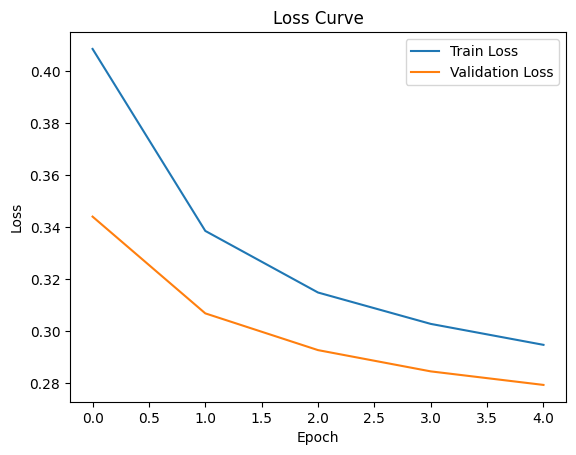

In [ ]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Train/val split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['description'].tolist(), y, test_size=0.2, random_state=42)

# Tokenize
train_enc = tokenizer(train_texts, padding=True, truncation=True, max_length=512, return_tensors='pt')
val_enc = tokenizer(val_texts, padding=True, truncation=True, max_length=512, return_tensors='pt')

# Datasets
train_dataset = MovieDataset(train_enc, train_labels)
val_dataset = MovieDataset(val_enc, val_labels)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)

train_losses, val_losses = [], []
val_accuracies = []

# Training loop with validation loss
for epoch in range(5):
    model.train()
    epoch_train_loss = 0
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask)
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()

    train_losses.append(epoch_train_loss / len(train_loader))

    # Validation loss
    model.eval()
    correct = 0
    total = 0
    epoch_val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask)
            loss = loss_fn(outputs, labels)
            epoch_val_loss += loss.item()

            top1_preds = torch.argmax(outputs, dim=1)  # shape: (batch_size,)

            for pred, true_labels in zip(top1_preds, labels):
                if true_labels[int(pred)] == 1:
                    correct += 1
                total += 1

    val_losses.append(epoch_val_loss / len(val_loader))
    val_accuracy = correct / total
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1} - Train Loss: {train_losses[-1]:.4f} | Val Loss: {val_losses[-1]:.4f} | Val Top-1 Accuracy: {val_accuracy:.4f}")

# Plotting
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title("Loss Curve")
plt.show()


In [8]:
from google.colab import drive
import torch
import pickle
import os

# 1. Mount Google Drive
# drive.mount('/content/drive')

# 2. Create a directory for your model
save_dir = '/content/drive/My Drive/movie_genre_model2'
os.makedirs(save_dir, exist_ok=True)

# 3. Save model weights (PyTorch)
model_path = os.path.join(save_dir, 'genre_classifier.pt')
torch.save(model.state_dict(), model_path)

# 4. Save tokenizer
tokenizer_path = os.path.join(save_dir, 'tokenizer')
tokenizer.save_pretrained(tokenizer_path)

# 5. Save MultiLabelBinarizer
mlb_path = os.path.join(save_dir, 'mlb.pkl')
with open(mlb_path, 'wb') as f:
    pickle.dump(mlb, f)

# 6. Save metadata (optional)
metadata = {
    'max_length': 512,  # Your tokenization parameter
    'threshold': 0.5    # Your prediction threshold
}
import json
with open(os.path.join(save_dir, 'metadata.json'), 'w') as f:
    json.dump(metadata, f)

print(f"Model saved to {save_dir}")
print(os.listdir(save_dir))

Model saved to /content/drive/My Drive/movie_genre_model2
['tokenizer', 'genre_classifier.pt', 'metadata.json', 'mlb.pkl']


In [22]:
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['description'].tolist(), y, test_size=0.2, random_state=42)

# Tokenize
train_enc = tokenizer(train_texts, padding=True, truncation=True, max_length=512, return_tensors='pt')
val_enc = tokenizer(val_texts, padding=True, truncation=True, max_length=512, return_tensors='pt')

# Datasets
train_dataset = MovieDataset(train_enc, train_labels)
val_dataset = MovieDataset(val_enc, val_labels)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)


Epoch 1 - Train Loss: 0.4015 | Val Loss: 0.3319 | Val Top-1 Accuracy: 0.4981
Epoch 2 - Train Loss: 0.3274 | Val Loss: 0.3017 | Val Top-1 Accuracy: 0.5590
Epoch 3 - Train Loss: 0.3073 | Val Loss: 0.2895 | Val Top-1 Accuracy: 0.5777
Epoch 4 - Train Loss: 0.2966 | Val Loss: 0.2825 | Val Top-1 Accuracy: 0.5966
Epoch 5 - Train Loss: 0.2891 | Val Loss: 0.2781 | Val Top-1 Accuracy: 0.6076
Epoch 6 - Train Loss: 0.2834 | Val Loss: 0.2745 | Val Top-1 Accuracy: 0.6198
Epoch 7 - Train Loss: 0.2789 | Val Loss: 0.2720 | Val Top-1 Accuracy: 0.6198
Epoch 8 - Train Loss: 0.2749 | Val Loss: 0.2698 | Val Top-1 Accuracy: 0.6259
Epoch 9 - Train Loss: 0.2716 | Val Loss: 0.2686 | Val Top-1 Accuracy: 0.6282
Epoch 10 - Train Loss: 0.2684 | Val Loss: 0.2673 | Val Top-1 Accuracy: 0.6319


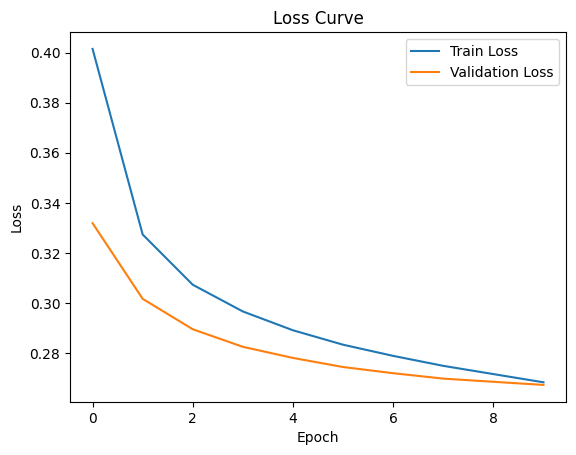

In [23]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

train_losses, val_losses = [], []
val_accuracies = []

# Training loop with validation loss
for epoch in range(10):
    model.train()
    epoch_train_loss = 0
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask)
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()

    train_losses.append(epoch_train_loss / len(train_loader))

    # Validation loss
    model.eval()
    correct = 0
    total = 0
    epoch_val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask)
            loss = loss_fn(outputs, labels)
            epoch_val_loss += loss.item()

            top1_preds = torch.argmax(outputs, dim=1)  # shape: (batch_size,)

            for pred, true_labels in zip(top1_preds, labels):
                if true_labels[int(pred)] == 1:
                    correct += 1
                total += 1

    val_losses.append(epoch_val_loss / len(val_loader))
    val_accuracy = correct / total
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1} - Train Loss: {train_losses[-1]:.4f} | Val Loss: {val_losses[-1]:.4f} | Val Top-1 Accuracy: {val_accuracy:.4f}")

# Plotting
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title("Loss Curve")
plt.show()


In [24]:
from sklearn.metrics import f1_score, precision_score, accuracy_score, multilabel_confusion_matrix

def evaluate_multilabel_model(model, dataloader, device):
    model.eval()
    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask)
            probs = torch.sigmoid(outputs)

            batch_preds = torch.zeros_like(probs)
            for i in range(probs.size(0)):
                k = int(labels[i].sum().item())
                if k > 0:
                    topk = torch.topk(probs[i], k).indices
                    batch_preds[i][topk] = 1

            all_labels.append(labels.cpu())
            all_preds.append(batch_preds.cpu())
            all_probs.append(probs.cpu())

    all_labels = torch.cat(all_labels).numpy()
    all_preds = torch.cat(all_preds).numpy()
    all_probs = torch.cat(all_probs).numpy()

    ### 1. Exact Match Accuracy
    exact_match_acc = accuracy_score(all_labels, all_preds)

    ### 2. Top-1 Accuracy
    top1_correct = 0
    for i in range(all_labels.shape[0]):
        top1_idx = np.argmax(all_probs[i])
        if all_labels[i][top1_idx] == 1:
            top1_correct += 1
    top1_accuracy = top1_correct / all_labels.shape[0]

    ### 3. Micro-F1 Score
    micro_f1 = f1_score(all_labels, all_preds, average='micro')

    ### 4. Average Accuracy per Genre
    conf_matrices = multilabel_confusion_matrix(all_labels, all_preds)
    genre_accuracies = []
    for cm in conf_matrices:
        tn, fp, fn, tp = cm.ravel()
        acc = (tp + tn) / (tp + tn + fp + fn)
        genre_accuracies.append(acc)
    avg_genre_accuracy = np.mean(genre_accuracies)

    return {
        "Exact Match Accuracy": exact_match_acc,
        "Top-1 Accuracy": top1_accuracy,
        "Micro-F1": micro_f1,
        "Average Genre Accuracy": avg_genre_accuracy
    }

results = evaluate_multilabel_model(model, val_loader, device)

for metric, value in results.items():
    print(f"{metric}: {value:.4f}")


Exact Match Accuracy: 0.3599
Top-1 Accuracy: 0.6319
Micro-F1: 0.5653
Average Genre Accuracy: 0.8869


In [26]:
# prompt: save model

# 1. Mount Google Drive (if not already mounted)
# drive.mount('/content/drive')

# 2. Create a directory for your model (if not already created)
save_dir = '/content/drive/My Drive/movie_genre_model3'
os.makedirs(save_dir, exist_ok=True)

# 3. Save model weights (PyTorch)
model_path = os.path.join(save_dir, 'genre_classifier.pt')
torch.save(model.state_dict(), model_path)

# 4. Save tokenizer
tokenizer_path = os.path.join(save_dir, 'tokenizer')
tokenizer.save_pretrained(tokenizer_path)

# 5. Save MultiLabelBinarizer
mlb_path = os.path.join(save_dir, 'mlb.pkl')
with open(mlb_path, 'wb') as f:
    pickle.dump(mlb, f)

# 6. Save metadata (optional)
metadata = {
    'max_length': 512,  # Your tokenization parameter
    'threshold': 0.5    # Your prediction threshold
}
with open(os.path.join(save_dir, 'metadata.json'), 'w') as f:
    json.dump(metadata, f)

print(f"Model saved to {save_dir}")
print(os.listdir(save_dir))


Model saved to /content/drive/My Drive/movie_genre_model3
['genre_classifier.pt', 'tokenizer', 'mlb.pkl', 'metadata.json']


In [32]:
num_genres = len(mlb.classes_)
genre_conf_matrix = np.zeros((num_genres, num_genres), dtype=int)

for true_row, pred_row in zip(all_labels, all_preds):
    true_indices = np.where(true_row == 1)[0]
    pred_indices = np.where(pred_row == 1)[0]
    for i in true_indices:
        for j in pred_indices:
            genre_conf_matrix[i][j] += 1


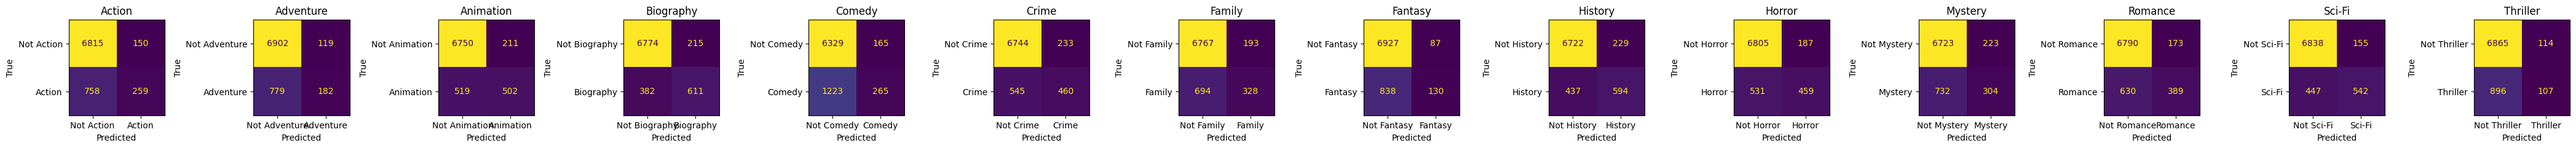

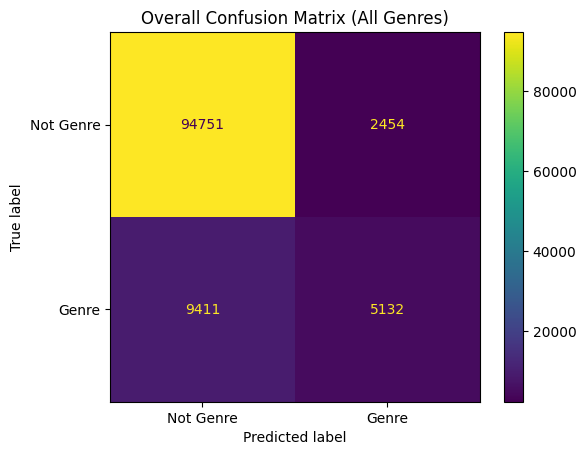

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay

# Assuming you have the following after validation:
# - val_loader: your validation DataLoader
# - model: your trained model
# - device: your torch device
# - mlb: your MultiLabelBinarizer (used for genre encoding)

all_true = []
all_pred = []
model.eval()
with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].cpu().numpy()
        outputs = model(input_ids, attention_mask).cpu().numpy()
        preds = (outputs > 0.5).astype(int)  # threshold for multi-label
        all_true.append(labels)
        all_pred.append(preds)

all_true = np.vstack(all_true)
all_pred = np.vstack(all_pred)

# Compute confusion matrices for each genre
mcm = multilabel_confusion_matrix(all_true, all_pred)

# Plot confusion matrix for each genre
genre_names = mlb.classes_
fig, axes = plt.subplots(1, len(genre_names), figsize=(3*len(genre_names), 3))
for i, (cm, genre) in enumerate(zip(mcm, genre_names)):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f'Not {genre}', genre])
    disp.plot(ax=axes[i] if len(genre_names) > 1 else axes, colorbar=False)
    axes[i].set_title(genre)
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('True')
plt.tight_layout()
plt.show()

# If you want a single matrix with all genres as columns (for visualization):
from sklearn.metrics import confusion_matrix
# Flatten predictions and truths for all genres
cm = confusion_matrix(all_true.flatten(), all_pred.flatten(), labels=[0,1])
ConfusionMatrixDisplay(cm, display_labels=['Not Genre', 'Genre']).plot()
plt.title('Overall Confusion Matrix (All Genres)')
plt.show()

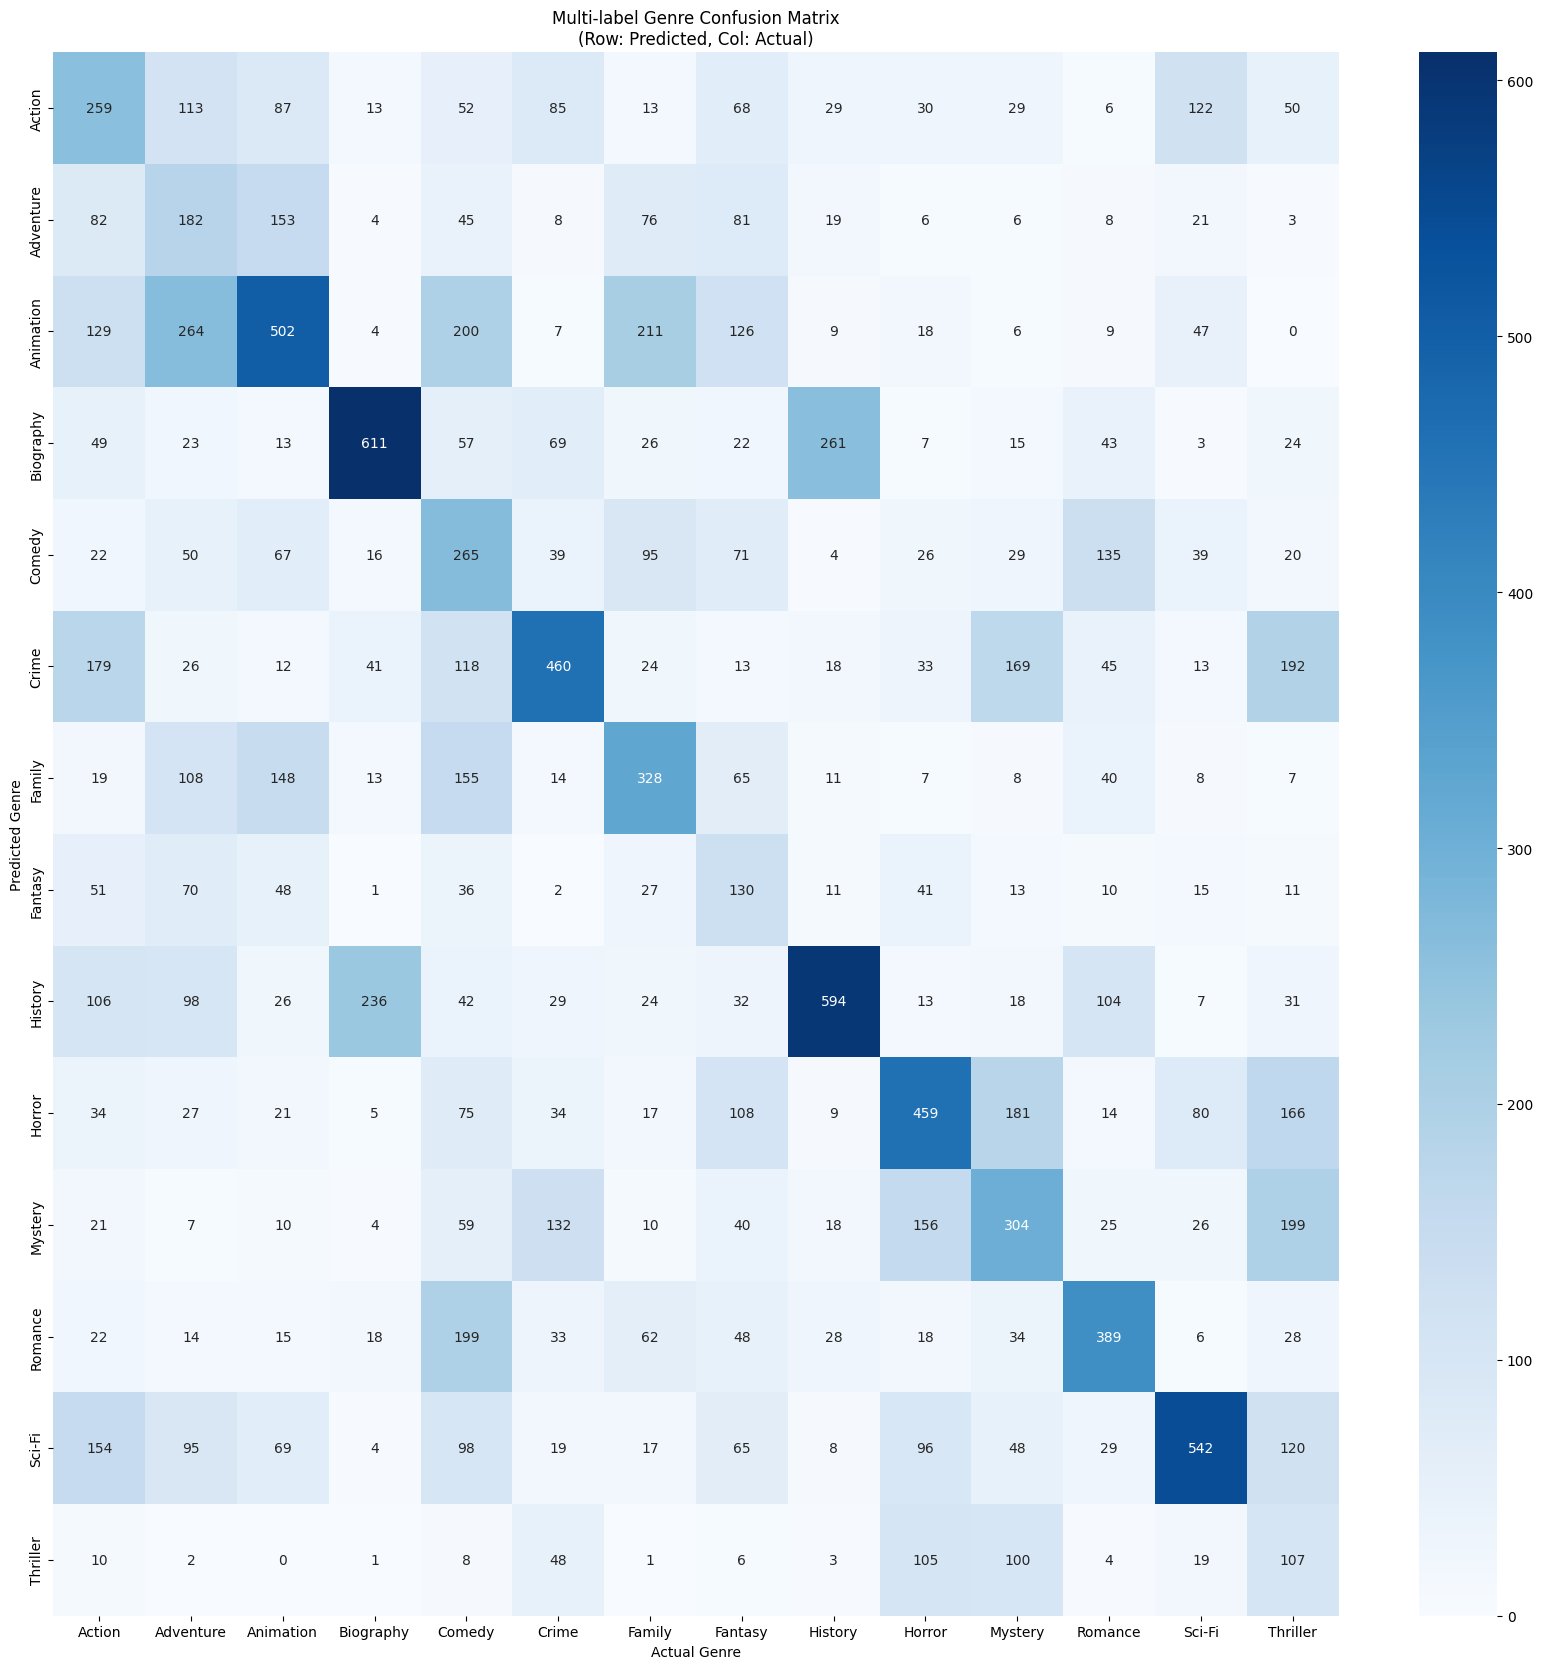

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# all_true: shape (num_samples, num_genres)
# all_pred: shape (num_samples, num_genres)
# genre_names: list of genre names (from mlb.classes_)

# Compute co-occurrence confusion matrix
num_genres = len(genre_names)
co_matrix = np.zeros((num_genres, num_genres), dtype=int)

for i in range(len(all_true)):
    true_indices = np.where(all_true[i] == 1)[0]
    pred_indices = np.where(all_pred[i] == 1)[0]
    for t in true_indices:
        for p in pred_indices:
            co_matrix[p, t] += 1  # row: predicted, col: actual

plt.figure(figsize=(1.2*num_genres, 1.2*num_genres))
sns.heatmap(co_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=genre_names, yticklabels=genre_names)
plt.xlabel('Actual Genre')
plt.ylabel('Predicted Genre')
plt.title('Multi-label Genre Confusion Matrix\n(Row: Predicted, Col: Actual)')
plt.tight_layout()
plt.show()